In [1]:
import pandas as pd
import numpy as np

In [2]:
df_1 = pd.read_csv('data/articles1.csv')
df_1

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."
...,...,...,...,...,...,...,...,...,...,...
49995,53287,73465,"Rex Tillerson Says Climate Change Is Real, but …",Atlantic,Robinson Meyer,2017-01-11,2017.0,1.0,NaN,"As chairman and CEO of ExxonMobil, Rex Tillers..."
49996,53288,73466,The Biggest Intelligence Questions Raised by t...,Atlantic,Amy Zegart,2017-01-11,2017.0,1.0,NaN,I’ve spent nearly 20 years looking at intellig...
49997,53289,73467,Trump Announces Plan That Does Little to Resol...,Atlantic,Jeremy Venook,2017-01-11,2017.0,1.0,NaN,Donald Trump will not be taking necessary st...
49998,53290,73468,Dozens of For-Profit Colleges Could Soon Close,Atlantic,Emily DeRuy,2017-01-11,2017.0,1.0,NaN,Dozens of colleges could be forced to close ...


### LOAD DICTIONARY AND ALL LISTS

In [3]:
import pickle

with open("lists/bow_corpus.txt", "rb") as fp:   # Unpickling
    bow_corpus = pickle.load(fp)

with open("lists/norm_corpus_bigrams.txt", "rb") as fp:   # Unpickling
    norm_corpus_bigrams = pickle.load(fp)

with open("lists/norm_papers.txt", "rb") as fp:   # Unpickling
    norm_papers = pickle.load(fp)

with open("lists/pre_papers.txt", "rb") as fp:   # Unpickling
    pre_papers = pickle.load(fp)

with open("lists/pre_titles.txt", "rb") as fp:   # Unpickling
    pre_titles = pickle.load(fp)

In [4]:
import nltk
import gensim

dictionary = gensim.corpora.Dictionary.load('models/dictionary.gensim')


### LOADING MALLET

The MALLET framework is a Java-based package for statistical natural language processing, document classification, clustering, topic modeling, information extraction, and other machine learning applications to text. MALLET stands for MAchine Learning for LanguagE Toolkit. It was developed by Andrew McCallum along with several people at the University of Massachusetts Amherst. The MALLET topic modeling toolkit contains efficient, sampling-based implementations of Latent Dirichlet Allocation, Pachinko Allocation, and Hierarchical LDA. To use MALLET’s capabilities, we need to download the framework.

In [10]:
### loading MALLET

#!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
    
#!unzip -q mallet-2.0.8.zip

MALLET_PATH = 'mallet-2.0.8/bin/mallet'

### LDA TUNING; FINDING THE OPTIMAL NUMBER OF TOPICS (SAVE ALL MODELS & COHERENCE SCORES)

Finding the optimal number of topics in a topic model is tough, given that it is like a model hyperparameter that you always have to set before training the model. We can use an iterative approach and build several models with differing numbers of topics and select the one that has the highest coherence score. To implement this method, we build the following function.

In [13]:
from tqdm import tqdm
def topic_model_coherence_generator(corpus, texts, dictionary,
                          start_topic_count=2, end_topic_count=10, step=1,
                                    cpus=1):
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH,
                                              corpus=corpus,
                                              num_topics=topic_nums,
                                              id2word=dictionary,
                                              iterations=500, workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model,
                                                    corpus=corpus,
                                                    texts=texts,
                                                    dictionary=dictionary,
                                                    coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
        
        ### saving each model
        mallet_lda_model.save('models/mallet/model_'+str(topic_nums)+'.gensim')
        
        
    return models, coherence_scores

In [14]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus,
                                                texts=norm_corpus_bigrams,
                                                dictionary=dictionary,
                                                start_topic_count=2,
                                                end_topic_count=30, step=1,
                                                cpus=16)


100%|██████████| 29/29 [2:42:54<00:00, 337.04s/it]


In [15]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1),
                        'Coherence Score': np.round(coherence_scores, 4)})

coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
28,30,0.5663
27,29,0.5596
24,26,0.5570
26,28,0.5537
22,24,0.5487
21,23,0.5479
23,25,0.5474
25,27,0.5456
18,20,0.5440
15,17,0.5374


In [16]:
# save coherence score df and coherence score list 
coherence_df.to_csv('models/mallet_scores/coherence_df.csv', index=False)

with open("models/mallet_scores/coherence_scores.txt", "wb") as fp:   #Pickling
    pickle.dump(coherence_scores, fp)

### VISUALIZE COHERENCE SCORES

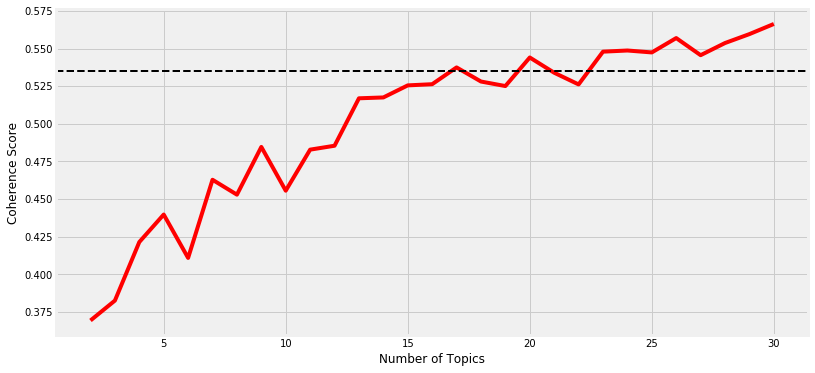

In [17]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline
x_ax = range(2, 31, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c="r")
plt.axhline(y=0.535, c="k", linestyle="--", linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')